# Le Challenge
Pour les jeux olympiques de 2024 Bouygues Telecom va déployer de nouveaux équipements réseau sur les zones des compétitions et des évènements pour gérer le nombre important de connexions.
Ces équipements sont d'un type nouveau et leur bon fonctionnement doit être supervisé en temps réél afin de s'assurer de la bonne expérience des utilisateurs du réseau.
Ils disposent d'une interface websocket qui permet la récupération en temps réél des indicateur système.
Le constructeur ne fourni pas de supervision et vous devez donc en développer une.
Heureusement la documentation est fournie par le constructeur : 

有时候，您可以通过这个界面接收到系统状态的4个值。
这些值非常重要，第一个值，第二个值，第三个值和第四个值依次排列。
您可以通过这些值了解系统是否正常运行，有时如果负载过大，这些值会有所不同。

Un canevas d'un système de supervision est fourni pour vous aider dans cette tâche... A vous de jouer !

Lorsque vous voyez `### .... ` il manque du code.<br>
Il en manque peut être à d'autres endroits

In [1]:
import websocket
import pandas as pd
import json

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, clear_output

from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR

import torch
from torch import tensor
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchinfo import summary

Si une GPU est disponible, elle sera utilisée sinon les calculs seront faits sur CPU

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device.type)

cpu


# MeasureHandler
Ceci est la fonction de traitement de chaque nouvelle mesure reçue.
De base elle ne fait que tracer les mesures reçues, il faudra la faire évoluer pour appeler le modèle entrainé et évaluer si le comportement est typique ou non.

In [3]:
class MeasureHandler:

    #Nombre de valeurs à conserver pour l'affichage
    buffer_size=200

    sequence_size=50

    def __init__(self):
        self.fig, (self.ax) = plt.subplots(1, figsize=(14, 7))

        # plot avec 2 axes y
        self.ax2 = self.ax.twinx()
  
        self.a=[]
        self.b=[]
        self.c=[]
        self.d=[]

        self.history=[]
   
        self.init_ax()

        self.cnt=0

    def init_ax(self):
        
        self.ax.clear()  
        self.ax2.clear()  

        self.ax2.yaxis.set_label_position("right")

        self.ax2.set_ylabel('Reconstruction loss')
        self.ax.set_ylabel('Input value')
                    
        #Echelle de gauche          
        self.ax.set_ylim(0, 1)

        #Echelle de droite
        self.ax2.set_ylim(0, 1e-4)
        
        #Echelle des abscisses
        self.ax.set_xlim(-self.buffer_size, 0)


    def handleMeasure(self,info):
        
        self.history.append(info)        

        if len(self.history)>self.sequence_size:
            self.history=self.history[-self.sequence_size:]

        self.a.append(info[0])
        self.b.append(info[1])
        self.c.append(info[2])
        self.d.append(info[3])

        #Conserver les dernières valeurs
        if len(self.a)>self.buffer_size :
            self.a=self.a[-self.buffer_size:]
            self.b=self.b[-self.buffer_size:]
            self.c=self.c[-self.buffer_size:]
            self.d=self.d[-self.buffer_size:]
                        
        #Nécessaire pour un affichage correct et dynamique
        self.init_ax()
    
        #Générer les abscisses à la bonne dimension
        x=[*range(-len(self.a),0)]

        self.ax.plot(x,self.d,'co-')
        self.ax.plot(x,self.c,'go-')
        self.ax.plot(x,self.b,'yo-')
        self.ax.plot(x,self.a,'bo-')

        #Mise à jour de l'affichage
        clear_output(wait = True)
        display(self.fig)

        #Nombre total de mesures reçues
        self.cnt = self.cnt+1


    #Fonction par défaut de la classe
    def __call__(self, *args, **kwds) :
        self.handleMeasure(args[0])    

# Cellule principale
Ceci est la connexion à l'équipement à superviser par websocket et l'invocation du MeasureHandler à chaque mesure.<br>
C'est cette cellule qu'il faut lancer comme traitemement principal.<br>
Il n'y a à priori aucune raison de modifier ce code...

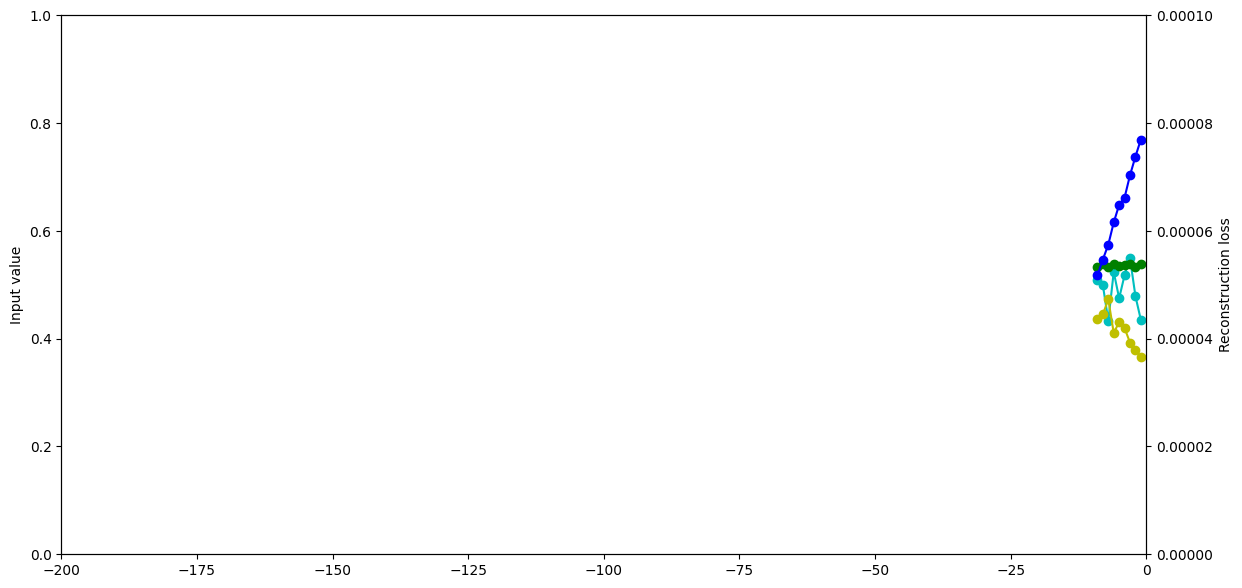


### closed ###
### stopped ###


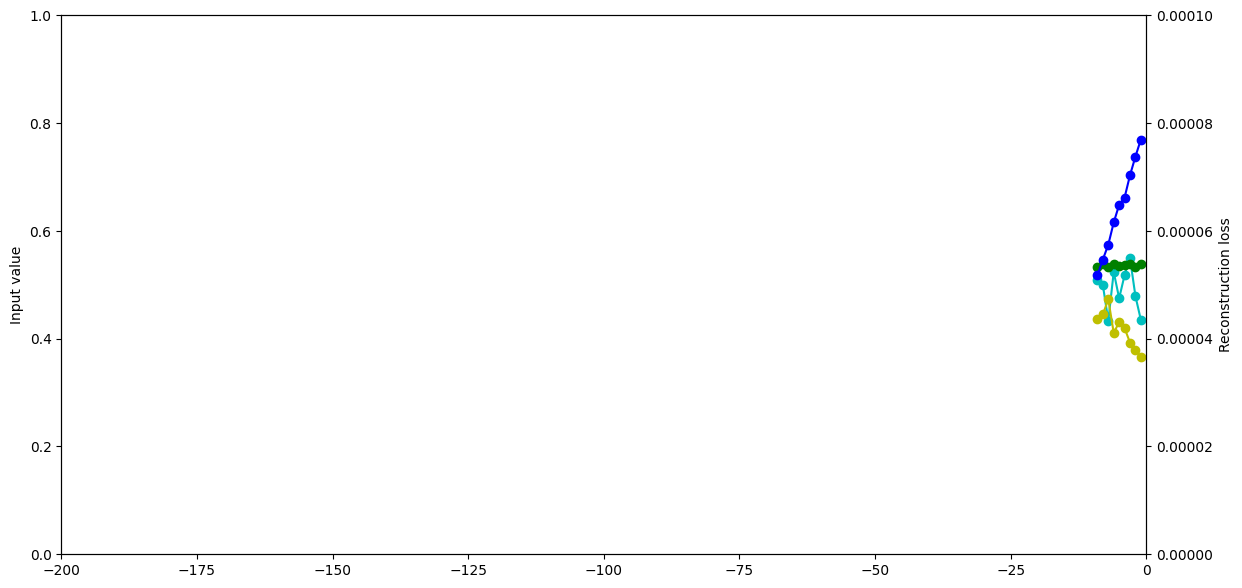

In [5]:
handler = MeasureHandler()

def on_message(ws, message):
    info =json.loads(message)
    
    handler(info)

def on_error(ws, error):
    print(error)

def on_close(ws, close_status_code, close_msg):
    print("### closed ###")

def on_open(ws):
    print("### connected ###")

ws = websocket.WebSocketApp("wss://iot.2bytl.fr/metrics",
                              on_open=on_open,
                              on_message=on_message,
                              on_error=on_error,
                              on_close=on_close)
try:
    ws.run_forever()
except:
    pass
    print('### stopped ###')    

# Données d'entrainement
Heureusement un stagiaire a pris le temps de collecter 200 000 mesures de l'équipement en fonctionnement nominal.<br>
L'équipement semble toujours bien fonctionner et aucune mesure anormale n'a pu être collectée.

Les données ne sont pas en trop grand nombre et peuvent être facilement chargées dans un dataframe Pandas

In [6]:
data = pd.read_csv('sample.csv',header=None,names=["Val1", "Val2", "Val3", "Val4"])
data

,Val1,Val2,Val3,Val4
0,0.131792,0.339551,0.328266,0.475787
1,0.150749,0.342564,0.334826,0.404029
2,0.177653,0.328278,0.337440,0.420387
3,0.210484,0.392668,0.345660,0.597654
4,0.237665,0.356969,0.356004,0.579112
...,...,...,...,...
199995,0.453068,0.354770,0.409619,0.485286
199996,0.486863,0.328537,0.411281,0.580699
199997,0.504551,0.341331,0.416204,0.497522
199998,0.541613,0.355690,0.420622,0.566971


Par chance les valeurs sont déjà entre 0 et 1, donc pas besoin de normaliser.

# Construction du modèle
Vous n'avez pas de données d'un équipement qui dysfonctionne... Vous ne pouvez donc pas envisager un entrainement supervisé de "classifier" avec des classes de sortie type OK - KO.
Pour traiter ce type de problème vous devez apprendre à un réseau de neuronne à reconstruire la "normalité". Ce type de réseau de neuronne s'appelle en Auto Encoder car il apprend à encoder puis à décoder le signal d'entrée pour le reproduire au mieux.<br>
https://fr.wikipedia.org/wiki/Auto-encodeur

Dans ce cas, il faut traiter des séquences car c'est la suite des valeurs qu'il faut examiner plutôt que leur valeur instantannée.

Pour traiter les séquences numériques les réseaux de neuronnes les plus classiques sont les LSTM: Long Short Term Memory.<br>
https://fr.wikipedia.org/wiki/R%C3%A9seau_de_neurones_r%C3%A9currents

Une solution pour assurer cette supervision sans avoir observé de cas particulier de dysfonctionnement est donc un LSTM - Autoencoder:
<div>
<img src="https://www.researchgate.net/profile/Hoang_Duy_Trinh2/publication/336594630/figure/fig2/AS:814792885420033@1571273170513/LSTM-Autoencoder-for-Anomaly-Detection.png" width="400"/>
</div>

Voici les préconisations pour construire le modèle : (les chiffres donnés sont des ordres de grandeur qui peuvent être modifiés)<br>
Fournir un paramètre au constructeur qui est le nombre de features (ici 4)
Créer un encodeur à 2 niveaux: <br>
1. LSTM nb_features --> nb_features * 40
2. LSTM nb_features *40 --> nb_features * 15

Par rapport au schéma ci-dessus nb_features * 15 est donc la représentation compressée (z)

Créer un décodeur à 2 niveaux: <br>
1. LSTM nb_features * 15 --> nb_features * 40
2. Dense (linear) nb_features * 40 --> nb_features

Il aurait été possible d'utiliser 2 LSTM dans le décodeur mais il est plus léger de finir par un réseau dense et cela devrait donner des résultats acceptables.

La documentation du LSTM : https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
Il est important d'utiliser l'argument batch_first = True sans quoi la génération des données d'entrée est plus complexe<br>
Les paramètres à fixer sont input_size et hidden_size<br>
Vous n'utiliserez ni les hidden_state ni les cell_state dans cet exemple.<br>
Regardez bien le format de sortie de l'appel au LSTM.<br>

La documentation de la couche dense (Linear) : https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

Vous pourrez trouver des exemples d'auto-encodeur LSTM avec un passage uniquement du dernier niveau de hidden_state entre l'encodeur et le décodeur.<br>
Ceci est un schéma courant mais qui ne fonctionnera pas bien dans notre cas, en particulier à cause de la courbe bleue (Val1) qui est très discontinue. L'auto-encodeur a besoin que l'ensemble de la séquence soit transmis pour fonctionner correctement.

Regardez un exemple de construction de réseau de neurones :<br>
https://pytorch.org/docs/stable/generated/torch.nn.Module.html

Si vous vous perdez dans les tailles utilisez quelque chose comme `print(x.shape)`

In [ ]:
class SuperviserModel (nn.Module):

    def __init__(self, nb_features):
        super().__init__()
        self.nb_features = nb_features  # this is the number of features
        self.hidden_size = nb_features*40
        self.encoded_size = nb_features*15

        ### ....

    #Méthode forward : sortie = f(entrée)
    #Sortie et entrée on la même "forme" : batch_size, sequence_size, nb_features
    def forward(self, x):


        ### ....

        return decoded

# Préparation des données d'entrainement
Pour entrainer un LSTM il faut lui fournir des séquences.
La taille des séquences est importante pour son bon entrainement:
* Trop courtes il aura du mal à bien comprendre l'évolution des valeurs.
* Trop longues l'entrainement sera très lourd et il ne sera pas assez générique.

Avec pytorch la classe qui sert à accéder aux données est Dataset.<br>
Le Dataset doit fournir des données de type `tensor` et il est préférable pour les performances de faire une seule fois la transformation sur les données d'entrée.

La méthode `__getitem__` est appelée pour récupérer chaque valeur à l'index i<br>
Pour avoir des séquence vous devrez retourner une portion des données d'entrée entre i et i+seqlen

La méthode `__len__` est appelée pour récupérer la longueur du dataset

Attention à ne pas dépasser la longueur totale de votre dataframe contenant les données d'entrainement 😉

In [ ]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, sequence_length):
        self.features = dataframe.columns
        self.seqlen = sequence_length
        #Passage en tensor pytorch une fois pour toute
        self.x = tensor(dataframe[self.features].values).float()

    def __len__(self):
        ### ....

    def __getitem__(self, i): 
        ### ....

Fixez une longueur de séquence entre 5 et 10 par exemple et créez votre dataset d'entrainement<br>
Affichez la taille d'un enregistrement qui devrait être [sequence_length,nb_features]<br>
Affichez quelques valeurs pour vérifier que le format est correct<br>

In [ ]:
sequence_length = ### ....

train_dataset = SequenceDataset(
    data,
    sequence_length=sequence_length
)

print (train_dataset[10].shape)

for i in range (10,12):
    print(train_dataset[i])


Un réseau de neurone ne s'entraine jamais valeur par valeur car il aurait trop de mal à converger.<br>
Une notion clé pour un entrainement est la taille de batch. Cela représente le nombre d'enregistrements qui font être pris dans l'évaluation de l'erreur (loss) et la back-propagation qui ajustera les poids des différentes cellules en fonction des gradiants.<br>
Dans pytorch la classe qui sert en général à charger par batch le dataset dans l'entrainement est le `DataLoader` <br>
Il prend en entrée le dataset et la taille de batch<br>
Il est en général important de positionner shuffle=True afin que les données soient passées aléatoirement et que l'entrainement ne voit pas toujours passer les données regroupées de la même manière suivant les epochs(passage de l'ensemble du dataset)<br>
https://pytorch.org/docs/stable/data.html

Vérifiez la taille d'un enregistrement qui devrait être (batch_size,sequence_length,nb_features)<br>

In [ ]:
train_loader = ### ....
x = next(iter(train_loader))
print(x.shape)
print(x)

# Fonction d'entrainement

Pour entrainer un modèle il faut plusieurs éléments clé:
* Le dataloader qui permet de sélectionner les lots (batchs) de valeurs
* Un optimizer qui sera en charge de modifier les poids des cellules du réseau
* Une loss-function qui sera en charge de calculer la valeur de l'erreur (loss)
* Optionnellement un scheduler qui sera en charge de faire évoluer le taux d'apprentissage (learning_rate) en général en le baissant au cours de l'apprentissage pour aider à la convergence du modèle

Assez classiquement on utilisera une loss_function MSE (MeanSquareError) et un optimizer Adam.<br>
Pour faire simple on prend ici une baisse exponentielle du taux d'apprentissage

Avant de rentrer dans la boucle le modèle doit être positionné en mode apprentissage afin qu'il maintienne les gradients

Pour chaque batch 
* reinitialiser les gradients
* copier la séquence vers la gpu si nécessaire
* calculer la sortie du modèle pour seq
* calculer la loss de la recontruction de la séquence
* faire la back-propagation
* faire avancer l'optimizer
* faire avancer le scheduler

https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop

In [ ]:
def train_model(model, loader, n_epochs):
  optimizer = Adam(model.parameters(), lr=1e-2)
  scheduler = ExponentialLR(optimizer, gamma=0.9995)
  loss_func =  nn.MSELoss().to(device)

  model.train() #on positionne le modèle en mode entrainement pour le calcul des gradients

  for epoch in range(1, n_epochs + 1):
    for i,seq in enumerate(loader):

      ### ....

      #Affichage toutes les 100 itérations
      if i%100==0 : 
        print(f'Epoch {epoch}-{i}  lr {scheduler.get_last_lr()} train loss {loss}')

# Entrainement
* Créer le modèle avec 4 features
* Copier le modèle sur GPU si disponible
* Faire l'entrainement. 1 epoch donne déjà un résultat utilisable vu le nombre de données d'entrainement. 2 epochs sera mieux si vous avez le temps.

L'entrainement ne devrait pas prendre plus de 5 minutes par epoch sur un ordinateur personnel.

In [ ]:
model = ### ....

Sauvegarder le modèle

In [ ]:
torch.save(model, 'model.pt')

Recharger le modèle et afficher sa structrure

In [ ]:
model=torch.load('model.pt')
summary(model)


# Evaluation du modèle
Créer une fonction permettant d'évaluer la "Loss" de la reconstruction d'une séquence.
Rappelez vous que le modèle attend un tenseur de taille (batch_size,sequence_length,nb_features)
Vous devez donc ajouter une dimension batch à la séquence avant de la passer au modèle.

In [ ]:
def check_sequence(seq) :
    loss_function =  nn.MSELoss().to(device)
    model.eval()
    with torch.no_grad():
        x = seq.to(device)
        x = x.unsqueeze(0) #Remet une dimension ce qui revient à une taille de batch de 1
        outputs = model.forward(x)
        loss = loss_function(outputs,x).item()
        return loss

Pour évaluer ce que donne le modèle, créer une fonction qui traite quelques séquences issues d'un dataSet. 
La longueur de la séquence évaluée peut être modifée. Regardez graphiquement les valeurs reçues de l'équipement et évaluer une taille de séquence qui serait à vérifier.

In [ ]:
def loss_stats(data):

    test_seq_len = ### ....

    losses=[]

    for a in range (0,500):
        d = data.iloc[a*100:(a*100+test_seq_len)].values
        v = tensor(d).float()
        l1 = check_sequence(v)
        losses.append(l1)

    print ('max loss',np.max(losses))
    print ('min loss',np.min(losses))
    print ('mean loss',np.mean(losses))

Evaluer ce que cela donne sur les données disponibles...

In [ ]:
loss_stats(data)

N'ayant aucune idée de ce qui se passe lors d'un dysfonctionnement, ajouter un peu de bruit à nos données puis refaire un test.

In [ ]:
data2 = data.copy()
data2 = ### ....

Essayer également des données totalement aléatoires...

In [ ]:
data3 = ### ....

Maintenenant vous avez les ordres de grandeur de la "reconstruction loss" pour des valeurs habituelles, en écart ou aberrantes.
Cela doit vous permettre de fixer le seuil à partir duquel vous allez considérer que le système dysfonctionne.

# Finaliser le superviseur

Afin d'avoir une supervision, il reste à intégrer la fonction check_sequence dans le measure_hander<br>

Tracer un histogramme pour la loss en utilisant l'axe de droite (ax2)

Fixer un seuil d'anomalie, faire en sorte que les barres soient vertes pour les valeurs en dessous du seuil et rouges au dessus.<br>
https://stackoverflow.com/questions/69043592/how-to-choose-bar-color-if-value-is-positive-or-negative

L'évaluation du modèle est couteuse en cpu, temps, énergie.<br>
Si vous faites l'évaluation pour chaque nouvelle mesure vous n'aurez pas un résultat très éco-responsable et de plus votre superviseur risque de prendre du retard par rapport au temmps réél. Vous allez être amenés à n'évaluer la séquence que tous les n points. Tous les 3 points est une bonne première approche.